
# Setup of the environment



We download and install the environment of HOOMD-blue and OpenMM with their respective plugins.


In [1]:
%%bash

BASE_URL="https://drive.google.com/u/0/uc?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7&export=download"
wget -q --load-cookies /tmp/cookies.txt "$BASE_URL&confirm=$(wget -q --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')" -O pysages-env.zip
rm -rf /tmp/cookies.txt

In [2]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [3]:
%%bash

mkdir -p $PYSAGES_ENV
unzip -qquo pysages-env.zip -d $PYSAGES_ENV
rm pysages-env.zip

In [4]:
import os
import sys

ver = sys.version_info

sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")


## PySAGES

The next step is to install PySAGES.
First, we install the jaxlib version that matches the CUDA installation of this collab setup. See the JAX documentation [here](https://github.com/google/jax) for more details.


In [5]:
%%bash

pip install -q --upgrade pip &> /dev/null
# Installs the wheel compatible with CUDA.
pip install -q --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html &> /dev/null


We test the jax installation and check the versions.


In [6]:
import jax
import jaxlib
print(jax.__version__)
print(jaxlib.__version__)

0.2.27
0.1.75



Now we can finally install PySAGES. We clone the newest version from [here](https://github.com/SSAGESLabs/PySAGES) and build the remaining pure python dependencies and PySAGES itself.


In [7]:
%%bash

rm -rf PySAGES
git clone https://github.com/SSAGESLabs/PySAGES.git &> /dev/null
cd PySAGES
pip install -q . &> /dev/null


# Umbrella integration

In [this tutorial](https://github.com/SSAGESLabs/PySAGES/docs/notebooks/Harmonic_Bias_PySAGES_HOOMD.md), we demonstrated how PySAGES can be used to run a single simulation with a biasing potential.
However, if we want to look into the free-energy landscape a single simulation is not enough. Instead, we have to perform a series of simulations along a path in the space of the collective variables (CVs). From the histograms of the biasing, we can deduce the differences in free energy. For a more detailed explanation look at the literature, for example [J. Kaestner 2009](https://doi.org/10.1063/1.3175798).

The first step here is also to generate a simulation snapshot that can be used as an initial condition.


In [8]:
!pip install gsd
import gsd
import gsd.hoomd
import numpy as np

class System:
    def __init__(self):
        self.L = 5
        self.N = 200

def post_process_pos(snapshot):
    box_size = snapshot.configuration.box[:3]
    snapshot.particles.image = np.rint(snapshot.particles.position / box_size)
    snapshot.particles.position -= snapshot.particles.image * box_size
    return snapshot

def get_snap(system):
    L = system.L
    snapshot = gsd.hoomd.Snapshot()
    snapshot.configuration.box = [L, L, L, 0, 0, 0]

    snapshot.particles.N = N = system.N

    snapshot.particles.types = ["A", "B"]
    snapshot.particles.position = np.zeros((N, 3))
    snapshot.particles.velocity = np.random.standard_normal((N, 3))
    snapshot.particles.image = np.zeros((N, 3), dtype=int)
    snapshot.particles.typeid = np.zeros(N, dtype=int)
    snapshot.particles.typeid += 1
    snapshot.particles.typeid[0] = 0

    rng = np.random.default_rng()
    for particle in range(N):
        snapshot.particles.position[particle, 0] = rng.random() * L - L / 2
        snapshot.particles.position[particle, 1] = rng.random() * L - L / 2
        snapshot.particles.position[particle, 2] = rng.random() * L - L / 2

    snapshot.particles.position[0, 0] = -np.pi
    snapshot.particles.position[0, 1] = -np.pi
    snapshot.particles.position[0, 1] = -np.pi

    return snapshot

system = System()
snap = get_snap(system)
snap = post_process_pos(snap)
snap.particles.validate()
with gsd.hoomd.open("start.gsd", "wb") as f:
    f.append(snap)


     |████████████████████████████████| 335 kB 7.6 MB/s            



For this simulation, we are using the PySAGES method `UmbrellaIntegration` so we start with importing this.

In the next step, we write a function that generates the simulation context. We need to make sure that the context can depend on the replica of the simulation along the path. PySAGES sets variable `replica_num` in the keyword arguments of the function.
We also set some general parameters for all replicas.

In contrast to the single harmonic bias simulation, the simulation now contains an external potential `hoomd.external.periodic` which changes the expected density of particles. See hoomd-blue's [documentation](https://hoomd-blue.readthedocs.io/en/stable/module-md-external.html#hoomd.md.external.periodic) for details on the potential. For this example, the potential generates the free-energy landscape we are exploring.


In [9]:
import hoomd
import hoomd.md
import hoomd.dlext

import pysages
from pysages.colvars import Component
from pysages.methods import UmbrellaIntegration

In [10]:
params = {"A": 0.5, "w": 0.2, "p": 2}

"""
Generates a simulation context, we pass this function to the attribute `run` of our sampling method.
"""
def generate_context(**kwargs):
    hoomd.context.initialize("")
    context = hoomd.context.SimulationContext()
    with context:
        print(f"Operating replica {kwargs.get('replica_num')}")
        system = hoomd.init.read_gsd("start.gsd")

        hoomd.md.integrate.nve(group=hoomd.group.all())
        hoomd.md.integrate.mode_standard(dt=0.01)

        nl = hoomd.md.nlist.cell()
        dpd = hoomd.md.pair.dpd(r_cut=1, nlist=nl, seed=42, kT=1.)
        dpd.pair_coeff.set("A", "A", A=5., gamma=1.0)
        dpd.pair_coeff.set("A", "B", A=5., gamma=1.0)
        dpd.pair_coeff.set("B", "B", A=5., gamma=1.0)

        periodic = hoomd.md.external.periodic()
        periodic.force_coeff.set('A', A=params["A"], i=0, w=params["w"], p=params["p"])
        periodic.force_coeff.set('B', A=0.0, i=0, w=0.02, p=1)
    return context



With the ability to generate the simulation context, we start to set up the umbrella integration method - starting with the CV that describes the single A-particle along the varying axis of the external potential.


In [14]:
cvs = [Component([0], 0),]



Next, we define the path along the CV space. In this case, we start at position $-1.5$ and end the path at the position $1.5$. We are using linear interpolation with $25$ replicas.


In [15]:
centers = list(np.linspace(-1.5, 1.5, 25))


The next parameters we need to define and run the method are the harmonic biasing spring constant,
(which we set to to $50$), the log frequency for the histogram ($50$), the number of steps we discard
as equilibration before logging ($10^3$), and the number of time steps per replica ($10^4$).

Since this runs multiple simulations, we expect the next cell to execute for a while.


In [17]:
method = UmbrellaIntegration(cvs, 50.0, centers, 50, int(1e3))
raw_result = pysages.run(method, generate_context, int(1e4))
result = pysages.analyze(raw_result)

Operating replica 0
notice(2): Group "all" created containing 200 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 200
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:06 | Step 10000 / 10000 | TPS 1549.37 | ETA 00:00:00
Average TPS: 1549.08
---------
-- Neighborlist stats:
1751 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 25 / n_neigh_avg: 8.815
shortest rebuild period: 2
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 4 / n_max: 13 / n_avg: 7.40741
** run complete **
Operating replica 1
notice(2): Group "a


What is left after the run is evaluating the resulting histograms for each of the replicas. For a better visualization, we group the histogram into 4 separate plots. This also helps to demonstrate that the histograms overlap.


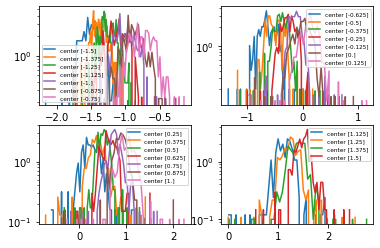

In [18]:
import matplotlib.pyplot as plt
bins =50
fig, ax = plt.subplots(2, 2)

counter = 0
hist_per = len(result["centers"])//4+1
for x in range(2):
    for y in range(2):
        for i in range(hist_per):
            if counter+i < len(result["centers"]):
                center = np.asarray(result["centers"][counter+i])
                histo, edges = result["histograms"][counter+i].get_histograms(bins=bins)
                edges = np.asarray(edges)[0]
                edges = (edges[1:] + edges[:-1]) / 2
                ax[x, y].plot(edges, histo, label=f"center {center}")
                ax[x, y].legend(loc="best", fontsize="xx-small")
                ax[x, y].set_yscale("log")
        counter += hist_per
while counter < len(result["centers"]):
    center = np.asarray(result["centers"][counter])
    histo, edges = result["histograms"][counter].get_histograms(bins=bins)
    edges = np.asarray(edges)[0]
    edges = (edges[1:] + edges[:-1]) / 2
    ax[1,1].plot(edges, histo, label=f"center {center}")
    counter += 1


And finally, as the last step, we can visualize the estimated free-energy path from the histograms and compare it with the analytical shape of the input external potential.


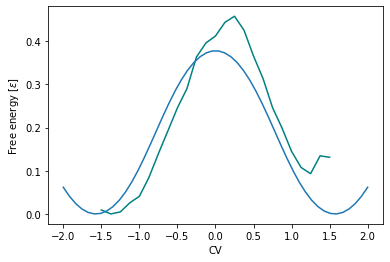

In [19]:
def external_field(r, A, p, w):
    return A * np.tanh(1 / (2 * np.pi * p * w) * np.cos(p * r))

fig, ax = plt.subplots()

ax.set_xlabel("CV")
ax.set_ylabel("Free energy $[\epsilon]$")
centers = np.asarray(result["centers"])
free_energy = np.asarray(result["free_energy"])
offset = np.min(free_energy)
ax.plot(centers, free_energy - offset, color="teal")

x = np.linspace(-2, 2, 50)
data = external_field(x, **params)
offset = np.min(data)
ax.plot(x, data - offset, label="test")



We can see, that the particle positions are indeed centered around the constraint values we set up earlier. Also, we see the shape of the histograms is very similar to the expected analytical prediction. We expect this since a liquid of soft particles is not that much different from an ideal gas.
